<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_4_Relativistic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [1]:
import math
import os

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm 

plt.ion()
from IPython.display import clear_output

HYPERPARAMETERS

In [2]:
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=200,
                     batch_size=64,
                     lr=.0002,
                     b1=.5,
                     b2=0.999,
                     n_cpu=8,
                     latent_dim=100,
                     img_size=32,
                     channels=1,
                     rel_avg_gan=True,
                     sample_interval=400)

print(hp.lr)

0.0002


SETUP

In [3]:
os.makedirs("images", exist_ok=True)

cuda = True if torch.cuda.is_available() else False
img_shape = (hp.channels, hp.img_size, hp.img_size)

def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

def to_img(x):
  x = x.clamp(0, 1)
  return x

def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, x, y):
  with torch.no_grad():  
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = make_grid(images, x, y).numpy()
    figure(figsize=(20,20))
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

GENERATOR

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = hp.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(hp.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, hp.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

DISCRIMINATOR

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(hp.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = hp.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


LOSS and MODELS

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()

generator = Generator()
discriminator = Discriminator()

if cuda:
  generator.cuda()
  discriminator.cuda()
  loss_fn.cuda()


OPTIMIZERS and TENSOR SETUP

In [7]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

GET the DATA

In [8]:
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
  datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(hp.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=hp.batch_size,
  shuffle=True,
)

Extracting ../../data/mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


TRAINING

Epoch:21:It302:DLoss0.153042271733284:GLoss0.9273865222930908


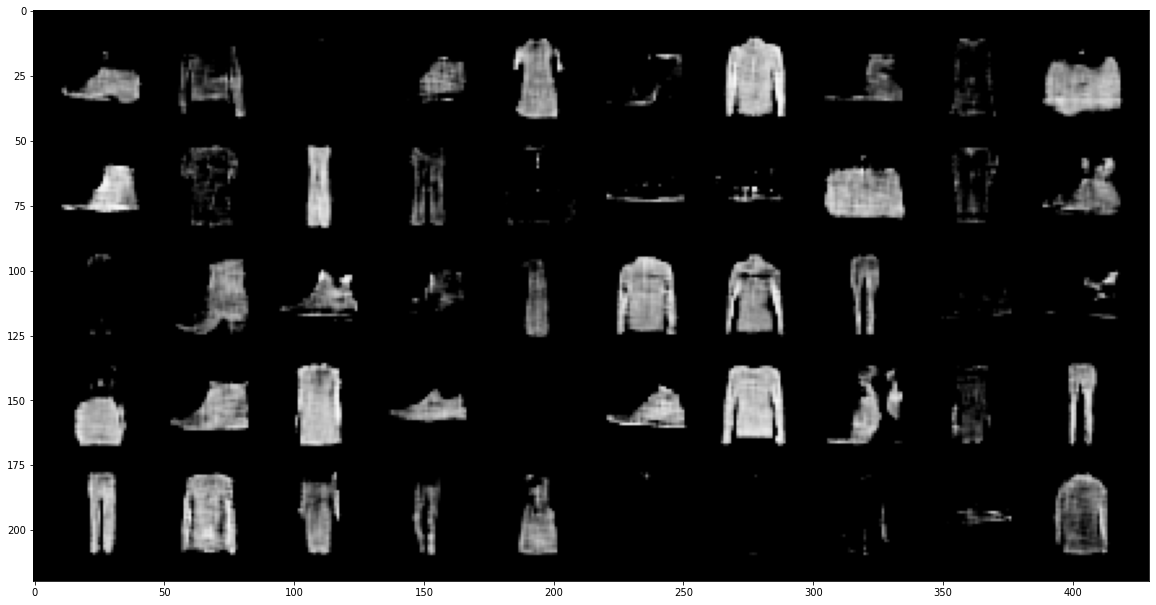

In [ ]:
for epoch in range(hp.n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

      # Adversarial ground truths
      valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(Tensor))

      # -----------------
      #  Train Generator
      # -----------------

      optimizer_G.zero_grad()

      # Sample noise as generator input
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], hp.latent_dim))))

      # Generate a batch of images
      gen_imgs = generator(z)

      real_pred = discriminator(real_imgs).detach()
      fake_pred = discriminator(gen_imgs)

      if hp.rel_avg_gan:
          g_loss = loss_fn(fake_pred - real_pred.mean(0, keepdim=True), valid)
      else:
          g_loss = loss_fn(fake_pred - real_pred, valid)

      # Loss measures generator's ability to fool the discriminator
      g_loss = loss_fn(discriminator(gen_imgs), valid)

      g_loss.backward()
      optimizer_G.step()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      optimizer_D.zero_grad()

      # Predict validity
      real_pred = discriminator(real_imgs)
      fake_pred = discriminator(gen_imgs.detach())

      if hp.rel_avg_gan:
          real_loss = loss_fn(real_pred - fake_pred.mean(0, keepdim=True), valid)
          fake_loss = loss_fn(fake_pred - real_pred.mean(0, keepdim=True), fake)
      else:
          real_loss = loss_fn(real_pred - fake_pred, valid)
          fake_loss = loss_fn(fake_pred - real_pred, fake)

      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()


      batches_done = epoch * len(dataloader) + i
      if batches_done % hp.sample_interval == 0:
        clear_output()
        print(f"Epoch:{epoch}:It{i}:DLoss{d_loss.item()}:GLoss{g_loss.item()}")          
        visualise_output(gen_imgs.data[:50],10, 10)
          #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)